<a href="https://colab.research.google.com/github/HarlinLee/PSC/blob/main/experiments/low_dim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Low-Dimensional Example

Here we set up a visualization for the optimization process in a low-dimensional example. We find an embedding $\alpha$ of $V_1(\mathbb{R}^2) = S^1$ into the Stiefel Manifold $V_1(\mathbb{R}^3)=S^2$ which minimizes the distances from each point to the image of $\alpha$.

In [1]:
!pip install pymanopt
!pip install geomstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 8.3 MB/s eta 0:00:00


In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/stiefelexp/

import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/stiefelexp"
output_folder = "/content/drive/MyDrive/stiefelexp"

import sys
sys.path.insert(0, DRIVE_PATH)

import numpy as np
from pymanopt.manifolds.stiefel import Stiefel
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

from utils import rotation_mat, get_samples, dist_Gr, dist_St, projection_cost, nuc_cost
from projections import manopt_alpha, PCA, pi_alpha_all, yhat_alpha_all

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Sampling from a neighborhood of $\alpha$

We take as an input some ground truth $\alpha\in V_n(\mathbb{R}^N)$, a radius $\epsilon$, and a desired number of data points $m$. We use the fact that the Stiefel manifold lies naturally in $\mathbb{R}^{N\times n}$, a vector space, so we first randomly sample $m$ points on $V_k(\mathbb{R}^n)$ which we will map into $V_k(\mathbb{R}^N)$ using $\alpha$. For each point, we add in a randomly chosen vector in $B(\epsilon)\subset \mathbb{R}^{N\times n}$. We then project the resulting vector back to $V_k(\mathbb{R}^N)$ by taking the orthogonal factor of its polar decomposition.

In [3]:
def stiefel_point_cloud(N,n,k,m,epsilon,alpha=None):
    """
    Given inputs, generates a list of points in a neighborhood of ground truth $\alpha$
    :param N: Larger ambient dimension
    :param n: Smaller dimension we aim to project to
    :param k: Columns
    :param m: Number of data points
    :param epsilon: Optional parameter, initial point in St(d,n) to begin gradient descent
    :param alpha: Optional parameter, ground truth as array. If not provided, one is randomly generated
    :return: dictionary with 3 keys: points, alpha, and epsilon
    """
    # Set up Stiefel manifolds of the right dimensions. By convention d
    St_Nk = Stiefel(N, k)
    St_nk = Stiefel(n, k)
    St_Nn = Stiefel(N, n)

    # If no initial point given, generate one
    if alpha is None:
        alpha = St_Nn.random_point()

    # Sample points in V_k(Rd) and map them into V_k(Rn)
    xs = get_samples(St_nk, m)
    initial_ys = [alpha.dot(x) for x in xs]

    # Add noise to initial_ys
    noise_vectors = [np.random.randn(N, k) for i in range(m)]
    normalized_noise = [v/np.linalg.norm(v)*epsilon for v in noise_vectors]
    perturbed_ys = np.add(initial_ys, normalized_noise)

    # Project each back down to Stiefel, keeping signs which may be dropped in QR decomp
    abs_ys = [np.linalg.qr(y)[0] for y in perturbed_ys]
    sing_vals = [np.linalg.qr(y)[1] for y in perturbed_ys]
    signs = np.array([np.sign(val) for val in sing_vals])
    ys = abs_ys * signs

    # Create dictionary with Manopt output and initial data, e.g. y_is, choice of alpha, etc.
    sample_result = {'points':ys, 'alpha':alpha, 'epsilon':epsilon, 'xs':xs}

    return sample_result


In [24]:
N = 3
n = 2
k = 1

data = stiefel_point_cloud(N,n,k,100,0.8)

ys = data['points']

## Visualization of PSC

In [5]:
def plot_noisy_3d_samples(Y, alpha, plot_alpha=False, plot_normal=False, highlight=False, fname='noisy_3d_sample.pdf'):
    # Create a sphere
    r = 1
    phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
    x = r*np.sin(phi)*np.cos(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(phi)

    #Set colours and render
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

    if highlight:
      ax.scatter(Y[1:, 0], Y[1:, 1], Y[1:, 2], color="k",s=20)
      ax.scatter(Y[0, 0], Y[0, 1], Y[0, 2], c='m', s=30)
    else:
      ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], color="k", s=20)
    ax.scatter(0, 0, 0, color='r',s=50)

    # plot alpha
    if plot_alpha:
      ax.plot([0, alpha[0, 0]], [0, alpha[1, 0]], [0, alpha[2, 0]], linewidth=4, linestyle='dotted', color='tab:pink')
      ax.plot([0, alpha[0, 1]], [0, alpha[1, 1]], [0, alpha[2, 1]], linewidth=4, linestyle='dotted', color='tab:pink')

    # # plot normal vector
    nv = np.cross(alpha[:, 0], alpha[:, 1])
    if plot_normal:
      ax.plot([0, np.sign(nv[2])*nv[0]], [0, np.sign(nv[2])*nv[1]], [0, np.sign(nv[2])*nv[2]], linewidth=2, linestyle='--', color='r')

    # plot great circle
    # https://math.stackexchange.com/questions/383711/parametric-equation-for-great-circle
    w = np.cross(nv, alpha[:, 0])
    theta = np.linspace(0, 2*np.pi, 101)
    p = np.array([w*np.cos(t) + alpha[:, 0]*np.sin(t) for t in theta])
    ax.plot(p[:,0], p[:, 1], p[:, 2])

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_box_aspect((1,1,1))
    # ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    # ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    # ax.set_zticks([-1, -0.5, 0, 0.5, 1])
    # ax.tick_params(axis='both', which='major', labelsize=18)
    # ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, fname), dpi=300)
    plt.show()


In [6]:
def plot_noisy_2d_samples(X, highlight=False, fname='noisy_2d_sample.pdf'):

    t = np.linspace(0,np.pi*2,100)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    circ = plt.Circle((0, 0), radius=1, edgecolor='tab:blue', facecolor='None')
    ax.add_patch(circ)
    if highlight:
      plt.scatter(X[1:, 0], X[1:, 1], c='k', s=20)
      plt.scatter(X[0, 0], X[0, 1], c='m', s=30)
    else:
      plt.scatter(X[:, 0], X[:, 1], c='k', s=20)
      ax.set_box_aspect((1))
#     ax.set_xticks([-1, -0.5, 0, 0.5, 1])
#     ax.set_yticks([-1, -0.5, 0, 0.5, 1])

    ax.set_xticks([])
    ax.set_yticks([])

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, fname), dpi=300)
    plt.show()

In [25]:
alpha_PCA = PCA(ys, n)
alpha_GD = manopt_alpha(ys, alpha_PCA)

St_Nn = Stiefel(N, n)
alpha_random = St_Nn.random_point() # for comparison

for alpha, name in zip([data['alpha'], alpha_PCA, alpha_GD, alpha_random],
                 ['True', 'PCA', 'GD', 'alpha_random']):
    print(name)
    print('    projection cost:', projection_cost(alpha, ys))
    print('    nuclear norm cost:', nuc_cost(alpha, ys))
    print()


Optimizing...
Terminated - min grad norm reached after 12 iterations, 0.57 seconds.

True
    projection cost: 0.15882286075213847
    nuclear norm cost: -0.9205885696239308

PCA
    projection cost: 0.15654635718549273
    nuclear norm cost: -0.9217268214072536

GD
    projection cost: 0.15645413412780043
    nuclear norm cost: -0.9217729329360995

alpha_random
    projection cost: 0.613095487967676
    nuclear norm cost: -0.6934522560161617



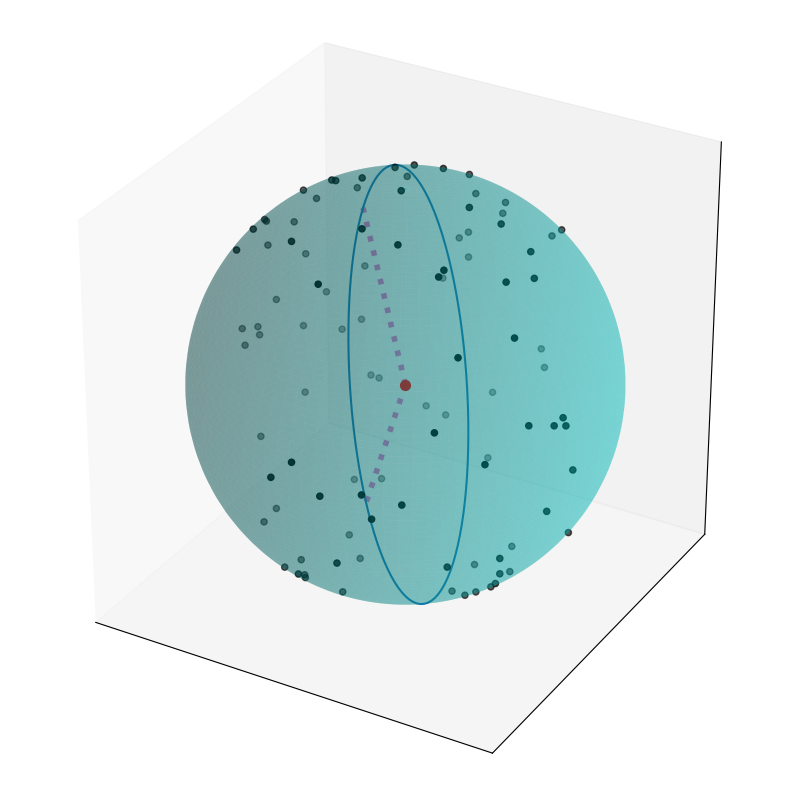

In [10]:
plot_noisy_3d_samples(np.array(ys).squeeze(), alpha_GD, plot_alpha=True, fname='lowdim_y_0.8.pdf')

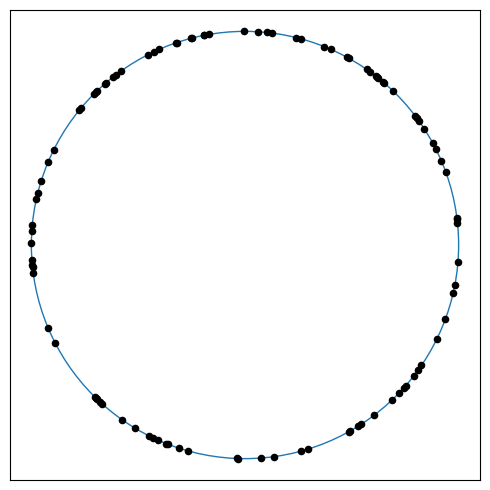

In [11]:
yhats = yhat_alpha_all(alpha_GD, ys)
plot_noisy_2d_samples(np.array(yhats).squeeze(), fname='lowdim_yhat_0.8.pdf')

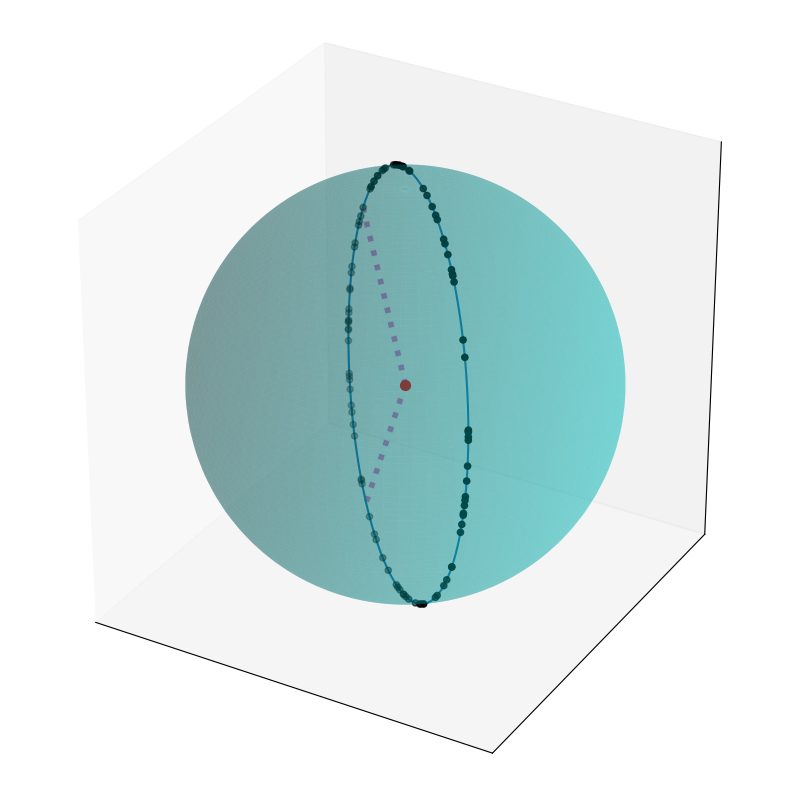

In [12]:
pi_ys = pi_alpha_all(alpha_GD, ys)
plot_noisy_3d_samples(np.array(pi_ys).squeeze(), alpha_GD, plot_alpha=True, fname='lowdim_piy_0.8.pdf')

## Grassmannians and Bundles

We first describe the manifold $V_2(\mathbb{R}^3)$ over which the optimization takes place. This is a bundle with fiber $O(2)\simeq S^1 \sqcup S^1$, where one copy can be thought of as $SO(2)$ and the other as $-Id\cdot SO(2)$. The base is $Gr(2,3)$, the Grassmannian of 2-planes in $R^3$, diffeomorphic to $Gr(1,3)\simeq \mathbb{R}P^2$ (the real projective plane). The total space of this bundle is $SO(3)$.

Later on, we'll need to use the description of $\mathbb{R}P^2$ as the quotient of the sphere $S^2$ by the action of the antipodal map. A fundamental domain for this action is the upper hemisphere of $S^2$.

## The Cost Function Descends to $Gr(1,3)$

Now, we are given $\{y_i\}\in S^2$, and the cost function for $\alpha\in V_2(\mathbb{R}^3)$ is simply $$\sum_i ||\alpha^T(y_i)||_*$$ where the norm here is the nuclear norm, the sum of singular values.

What makes this low-dimensional case tractable to compute by hand is the fact that $\alpha^T(y_i)\in \mathbb{R}^2$ is a vector, and the singular value of a vector is simply its $L^2$-norm. Thus we need only calculate the lengths $||\alpha^T(y_i)||$ as vectors in $\mathbb{R}^2$.

At this point we can observe that this quantity is $O(2)$-invariant, for if $U\in O(2)$ then $$||(\alpha\cdot U)^T(y_i)|| = ||U\alpha^T(y_i)|| = ||\alpha^T(y_i)||$$ since the norm here is in $\mathbb{R}^2$ and $U$ is distance-preserving. So in fact the cost function is well-defined on the Grassmannian, which means that we can graph it as a function over the disc (upper hemisphere).

## Simplifying the Cost Function

We showed early on that since $\alpha$ has orthonormal columns, it is in fact an isometric embedding. So it would be the same to compute the $L^2$-norms (lengths) of $\alpha(\alpha^T(y_i))\in \mathbb{R}^3$.

The map $\alpha(\alpha^T(v))$ is simply the projection of $v$ onto the subspace $Im(\alpha)$. So, the length of this vector is the singular value we need.

To find this, note that $y_i\in S^2$ so they have length 1. If we take the cross product of the columns of $\alpha$, we obtain the normal vector $\nu_\alpha$ to the plane we're projecting onto. The length (and singular value) we are looking for is $||(I-\nu_\alpha \nu_\alpha^\top)y_i||$.

Since all this really involved was the normal vector, it's just as good to optimize over normal vectors instead of thinking about planes. This is how we implement it below.

## Visualizing the loss landscape

Now we are ready to plot the graphs. Parametrize the upper hemisphere of $S^2$ in spherical coordinates with $\phi$ as the angle measured down from the north pole, and $\theta$ the angle measured counterclockwise from the positive $x$-axis. Letting $\theta\in[0,2\pi)$ and $\phi\in[0,\pi/2)$ gives the upper hemisphere of $S^2$.

In [19]:
def make_r_theta_vals(ys):
    N = ys[0].shape[0]
    thetas_radians = np.arange(0, 2.01*np.pi, np.pi/100.) #List of evenly spaced points between 0 and 2pi for theta, azimuth
    phis_radians = np.arange(0, np.pi/2, np.pi/50.) #List of evenly spaced points between 0 and pi for phi, inclination

    tr, pr = np.meshgrid(thetas_radians, phis_radians) #meshgrid these to make the full array, essentially the cartesian product

    #Use these parameter values to set up a grid of vectors in S2\subsetR3, in spherical coordinates
    xcoords = np.cos(tr)*np.sin(pr)
    ycoords = np.sin(tr)*np.sin(pr)
    zcoords = np.cos(pr)

    coords = np.dstack((xcoords, ycoords, zcoords))
    cost = np.zeros_like(xcoords)

    for i in range(coords.shape[0]):
        for j in range(coords.shape[1]):
            v = coords[i, j, :].reshape(-1, 1) # normal vector
            P = np.eye(N) - v.dot(v.T) # projection matrix on column space of alpha
            cost[i, j] = sum([np.sqrt((P.dot(y)).T.dot(P.dot(y))) for y in ys])/len(ys)

    #generate cost function values according to dot products with y_i
    #yprods = [xcoords*y[0]+ycoords*y[1]+zcoords*y[2] for y in ys] #List of inner products (y_i, n_alpha)
    #sing_vals = [np.sqrt(1-prod*prod) for prod in yprods] #Lengths of projections. Previously I just had the inner products here which made for incorrect but cooler-looking graphs
    #cost = sum(sing_vals)/len(yprods) #Add up lengths to get cost function. Previously I took the absolute value then summed

    return thetas_radians, phis_radians, cost

In [14]:
def stiefel_to_rp2(alpha):
    nv = np.cross(alpha[:, 0], alpha[:, 1])
    if nv[2]<0: #Ensures the point is on the upper hemisphere
        nv=-nv
    r = np.sqrt(sum(nv**2))
    phi = np.arccos(nv[-1]/r) # returns [0, pi]
    theta = np.arctan2(nv[1], nv[0]) # returns [-pi, pi]
    if theta < 0:
        theta += 2*np.pi # [0, 2pi]
    return theta, phi

In [15]:
def make_polar_plot(ys):
    fig = plt.figure(figsize=(10, 8)) #Set up size of graph
    ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True) #Set up polar coordinates

    thetas_radians, radii, z = make_r_theta_vals(ys) #Create the grid of function values using the function above
    pc = ax.pcolormesh(thetas_radians, radii, z, edgecolors='face', shading='nearest') #pcolormesh interpolates between the discrete function values

    xT = plt.xticks()[0] #Label the theta axis
    xL = ['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
    plt.xticks(xT, xL)

    yT = np.arange(0, 1.01*np.pi, np.pi/4) #Label the phi axis (radius)
    yL = ['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'$\pi$']
    plt.yticks(yT,yL, color='white')

    cbar = plt.colorbar(pc, shrink=0.8, pad = 0.15)

    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)

    nb = np.ceil(100*z.min())/100
    nc = np.floor(100*z.max())/100
    ticks = np.arange(nb, min(nc+0.01, z.max()), 0.05)

    cbar.ax.set_yticks(ticks)
    cbar.ax.set_yticklabels([str(np.around(t, 2)) for t in ticks])
    cbar.ax.tick_params(labelsize=18)

    #Show a color bar, move it a little bit to the right

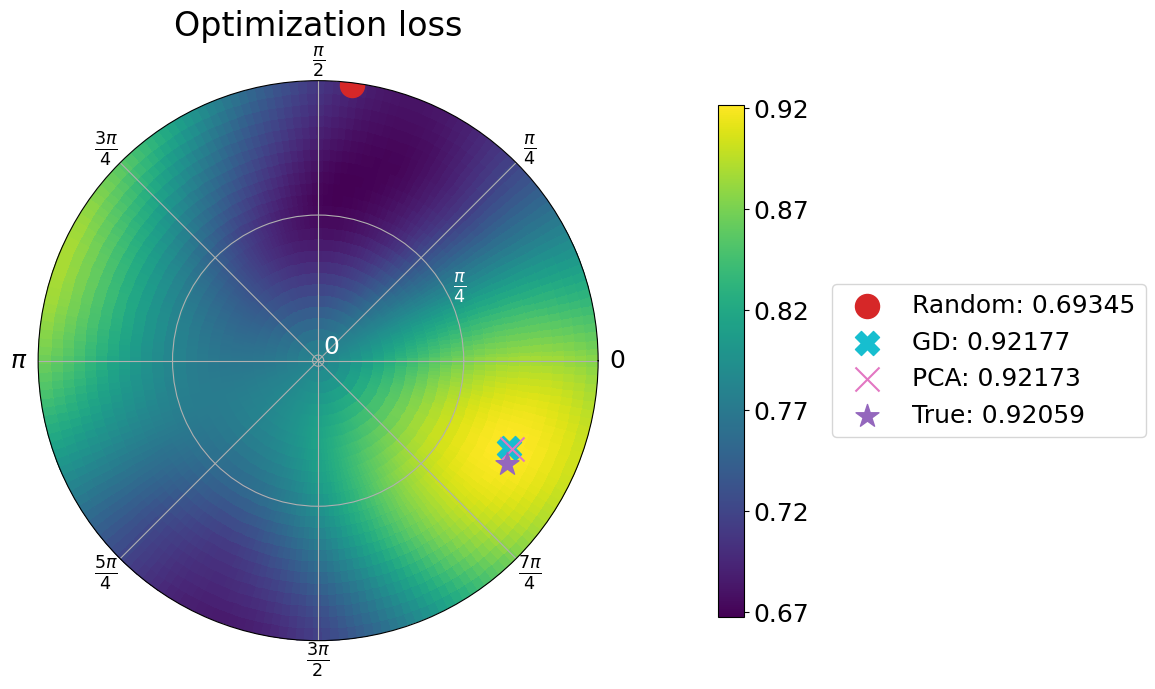

In [26]:
make_polar_plot(ys)

for alpha, color, marker, label in zip([alpha_random, alpha_GD, alpha_PCA, data['alpha']],
                                      ['tab:red', 'tab:cyan', 'tab:pink', 'tab:purple'],
                                      ['o', 'X', 'x', '*'],
                                      ['Random', 'GD', 'PCA', 'True']):
    t, p = stiefel_to_rp2(alpha)
    c = -1*nuc_cost(alpha, ys)
    plt.scatter(t, p, marker=marker, color=color, s=300, label=label + ': '+str(np.around(c, 5)))

plt.legend(loc=7, bbox_to_anchor=(2, 0., 0, 1), fontsize=18)
plt.title(r'Optimization loss', fontsize= 24)
# plt.tight_layout(rect=[0, 0, 1.5, 1.5])
plt.savefig(os.path.join(output_folder,'lowdim-opt.pdf'), dpi=300, bbox_inches = "tight")
plt.show()